# **Red neuronal convolucional para el diagnóstico de nódulos tiroideos según la clasificación EU-TIRADS**

## Por Alejandro Martínez Hernández

### Notebook 4/5

# **Creación de modelos**

Para la siguiente parte se crearan los siguientes modelos de clasificación:
- MobileNetV3
- ResNet
- VGG16
- VGG19
- Xception
- DenseNet121

Cada uno se evaluará con la misma tasa de aprendizaje y con dos tipos de optimizadores, Adam y SGD

In [2]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, VGG19, MobileNetV3Small, MobileNetV3Large, Xception, ResNet50, ResNet101, DenseNet121
from sklearn.model_selection import GroupShuffleSplit
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam, SGD
import matplotlib.pyplot as plt


def load_images(base_dir, input_size=(224, 224)):
    """
    Carga imágenes y etiquetas desde el directorio base.

    Args:
        base_dir (str): Directorio base donde están ubicadas las carpetas de imágenes.
        input_size (tuple): Tamaño al cual se redimensionarán las imágenes.

    Returns:
        data (np.array): Imágenes cargadas.
        labels (np.array): Etiquetas correspondientes.
        groups (np.array): Identificadores de los pacientes.
    """
    
    # Definir las categorías e inicializar listas para los datos, etiquetas y grupos
    categories = ['high', 'low']
    data = []
    labels = []
    groups = []

    # Recorrer cada categoría (high y low)
    for category in categories:
        # Obtener la ruta completa de la categoría
        path = os.path.join(base_dir, category)
        # Asignar el número de clase basado en el índice de la categoría
        class_num = categories.index(category)
        
        # Recorrer cada imagen en la carpeta de la categoría
        for img in os.listdir(path):
            # Obtener la ruta completa de la imagen
            img_path = os.path.join(path, img)
            # Leer la imagen usando OpenCV
            image = cv2.imread(img_path)
            
            # Comprobar si la imagen fue cargada correctamente
            if image is not None:
                # Convertir la imagen a escala de grises
                image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                # Redimensionar la imagen al tamaño especificado
                image = cv2.resize(image, input_size)
                # Replicar el canal de la imagen para convertirla a 3 canales
                image = np.stack((image,) * 3, axis=-1)
                # Añadir la imagen procesada a la lista de datos
                data.append(image)
                # Añadir la etiqueta correspondiente a la lista de etiquetas
                labels.append(class_num)
                # Extraer el identificador del paciente del nombre del archivo y añadirlo a la lista de grupos
                patient_id = img.split('_')[0]
                groups.append(patient_id)

    # Convertir las listas de datos, etiquetas y grupos en arrays de numpy
    return np.array(data), np.array(labels), np.array(groups)


def setup_image_generators(X_train, X_val, y_train, y_val):
    """
    Configura generadores de imágenes para entrenamiento y validación.

    Args:
        X_train (np.array): Imágenes de entrenamiento.
        X_val (np.array): Imágenes de validación.
        y_train (np.array): Etiquetas de entrenamiento.
        y_val (np.array): Etiquetas de validación.

    Returns:
        train_generator: Generador para el entrenamiento.
        val_generator: Generador para la validación.
    """
    
    # Configuración del generador de imágenes para el conjunto de entrenamiento
    train_datagen = ImageDataGenerator(
        rescale=1./255,  # Normaliza los valores de los píxeles a [0, 1]
    )

    # Configuración del generador de imágenes para el conjunto de validación
    validation_datagen = ImageDataGenerator(rescale=1./255)  # Normaliza los valores de los píxeles a [0, 1]

    # Crear el generador de imágenes para el conjunto de entrenamiento
    train_generator = train_datagen.flow(X_train, y_train)
    
    # Crear el generador de imágenes para el conjunto de validación
    val_generator = validation_datagen.flow(X_val, y_val)

    # Retornar los generadores configurados
    return train_generator, val_generator


def create_model(base_model_name, optimizer_name, input_shape=(224, 224, 3), learning_rate=0.01):
    """
    Crea un modelo de red neuronal secuencial utilizando una arquitectura base preentrenada.

    Args:
        base_model_name (str): Nombre del modelo base preentrenado a usar.
        optimizer_name (str): Nombre del optimizador a usar.
        input_shape (tuple): Dimensiones de las imágenes de entrada.
        learning_rate (float): Tasa de aprendizaje para el optimizador.

    Returns:
        model: Modelo compilado de TensorFlow.
    """
    
    # Diccionario de modelos base preentrenados
    model_dict = {
        'VGG16': VGG16,
        'VGG19': VGG19,
        'MobileNetV3Small': MobileNetV3Small,
        'MobileNetV3Large': MobileNetV3Large,
        'Xception': Xception,
        'ResNet50': ResNet50,
        'ResNet101': ResNet101,
        'DenseNet': DenseNet121
    }

    # Diccionario de optimizadores
    optimizer_dict = {
        'Adam': Adam(learning_rate=learning_rate),
        'SGD': SGD(learning_rate=learning_rate)
    }

    # Cargar el modelo base preentrenado sin la capa superior
    base_model = model_dict[base_model_name](include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False  # Congelar las capas del modelo base

    # Crear el modelo secuencial
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),  # Añadir capa de pooling global
        Dense(1, activation='sigmoid')  # Añadir capa de salida con activación sigmoide
    ])

    # Compilar el modelo con el optimizador y la función de pérdida especificados
    model.compile(optimizer=optimizer_dict[optimizer_name], loss='binary_crossentropy', metrics=['accuracy'])
    
    return model  # Retornar el modelo compilado


def train_model(base_model_name, optimizer_name, base_directory='db_unal/organized/images/cropped', input_size=(224, 224), learning_rate=0.01, epochs=1000):
    """
    Entrena un modelo de red neuronal utilizando una arquitectura base preentrenada y un optimizador especificado.

    Args:
        base_model_name (str): Nombre del modelo base preentrenado a usar.
        optimizer_name (str): Nombre del optimizador a usar.
        base_directory (str): Directorio base donde están ubicadas las carpetas de imágenes.
        input_size (tuple): Dimensiones de las imágenes de entrada.
        learning_rate (float): Tasa de aprendizaje para el optimizador.
        epochs (int): Número de épocas para el entrenamiento.

    Returns:
        None
    """
    # Cargar las imágenes
    X, y, groups = load_images(base_directory, input_size)

    # Dividir los datos en conjuntos de entrenamiento y validación
    gss = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=42)
    train_idx, val_idx = next(gss.split(X, y, groups=groups))

    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # Configurar generadores de imágenes
    train_gen, val_gen = setup_image_generators(X_train, X_val, y_train, y_val)

    # Crear y compilar el modelo
    model = create_model(base_model_name, optimizer_name, input_shape=(input_size[0], input_size[1], 3), learning_rate=learning_rate)

    # Calcular los pesos de clase para manejar datos desbalanceados
    weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
    class_weights = {i: weights[i] for i in range(len(weights))}

    # Configurar los callbacks
    early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=300, verbose=1, mode='min')

    # Entrenar el modelo
    history = model.fit(train_gen, validation_data=val_gen, epochs=epochs, class_weight=class_weights, callbacks=[early_stopping])

    # Evaluar el modelo en el conjunto de validación
    val_loss, val_accuracy = model.evaluate(val_gen)
    print(f'Validation accuracy: {val_accuracy:.4f}')

    # Métricas de desempeño
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    # Graficar la precisión del entrenamiento y la validación
    plt.figure(figsize=(10, 6))
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.ylim(0, 1.0)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Graficar la pérdida del entrenamiento y la validación
    plt.figure(figsize=(10, 6))
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylim(0, 1.0)
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

## **MobileNetV3**

### **Small Version**

#### **Adam Optimizer**

Epoch 1/1000
1/7 ━━━━━━━━━━━━━━━━━━━━ 23s 4s/step - accuracy: 0.4375 - loss: 0.7778

c:\Users\alema\Desktop\paper\nodulos_tiroideos\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 327ms/step - accuracy: 0.4858 - loss: 0.7303 - val_accuracy: 0.4783 - val_loss: 0.7874
Epoch 2/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 0.4491 - loss: 0.7391 - val_accuracy: 0.4783 - val_loss: 0.7809
Epoch 3/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.4759 - loss: 0.7112 - val_accuracy: 0.5217 - val_loss: 0.8416
Epoch 4/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.5528 - loss: 0.8030 - val_accuracy: 0.5217 - val_loss: 0.6946
Epoch 5/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 0.5409 - loss: 0.7190 - val_accuracy: 0.4783 - val_loss: 0.8561
Epoch 6/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 0.4412 - loss: 0.8241 - val_accuracy: 0.5217 - val_loss: 0.7347
Epoch 7/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.6131 - loss: 0.6798 - val_accuracy: 0.5217 - val_loss: 0.7303
Epoch 8/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.4660 - loss: 0.8629 - val_accuracy: 0.4783 - val_lo

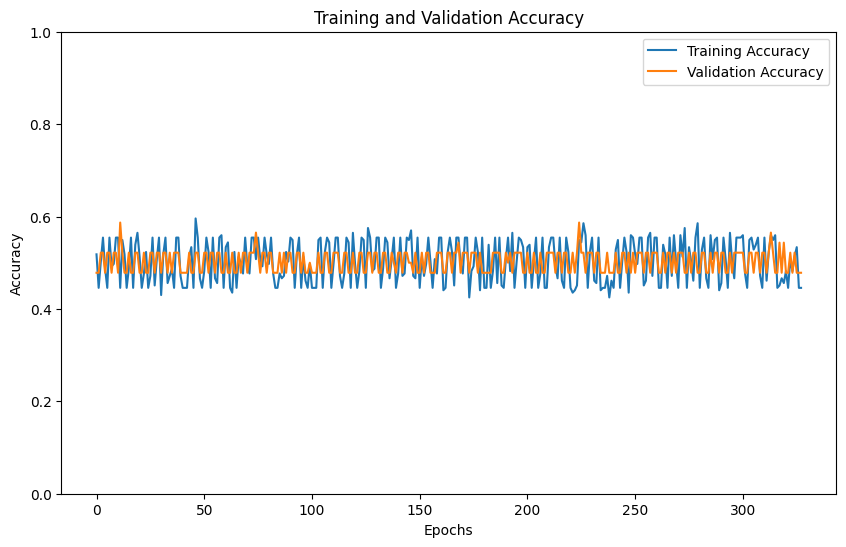

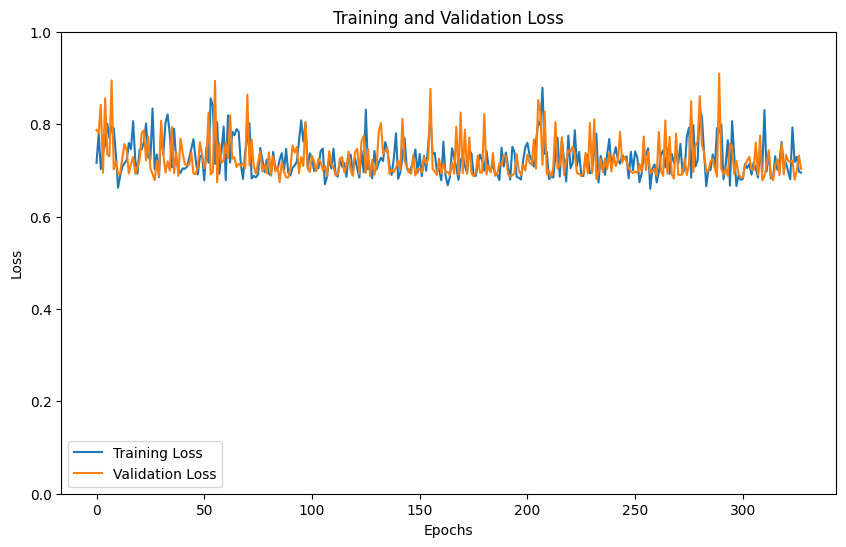

In [2]:
train_model('MobileNetV3Small', 'Adam')

#### **SGD optimizer**

Epoch 1/1000
1/7 ━━━━━━━━━━━━━━━━━━━━ 28s 5s/step - accuracy: 0.4688 - loss: 0.7245

c:\Users\alema\Desktop\paper\nodulos_tiroideos\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 338ms/step - accuracy: 0.5390 - loss: 0.6867 - val_accuracy: 0.5217 - val_loss: 0.6872
Epoch 2/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.4793 - loss: 0.7310 - val_accuracy: 0.4783 - val_loss: 0.6995
Epoch 3/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.4230 - loss: 0.6926 - val_accuracy: 0.5217 - val_loss: 0.6928
Epoch 4/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 0.4112 - loss: 0.7087 - val_accuracy: 0.5217 - val_loss: 0.7027
Epoch 5/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.5825 - loss: 0.6684 - val_accuracy: 0.5217 - val_loss: 0.6777
Epoch 6/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.5490 - loss: 0.7232 - val_accuracy: 0.4783 - val_loss: 0.6973
Epoch 7/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.4665 - loss: 0.7002 - val_accuracy: 0.4783 - val_loss: 0.7215
Epoch 8/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.4464 - loss: 0.7050 - val_accuracy: 0.5217 - val_lo

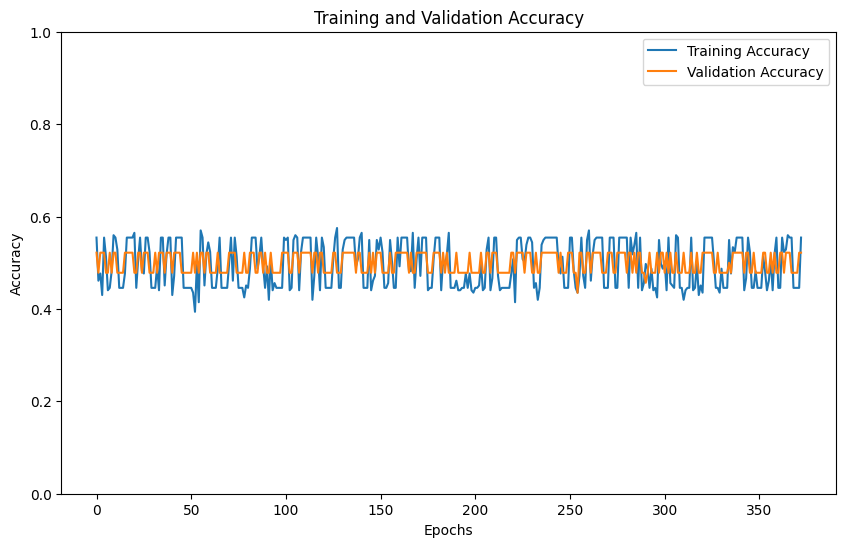

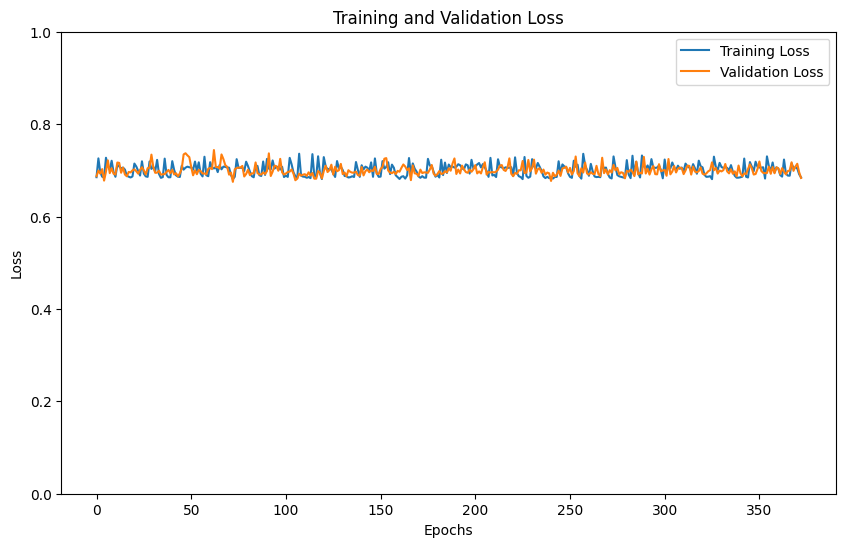

In [3]:
train_model('MobileNetV3Small', 'SGD')

### **Large Version**

#### **Adam Optimizer**

Epoch 1/1000


c:\Users\alema\Desktop\paper\nodulos_tiroideos\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 609ms/step - accuracy: 0.6064 - loss: 0.6781 - val_accuracy: 0.5217 - val_loss: 0.6974
Epoch 2/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 395ms/step - accuracy: 0.5655 - loss: 0.6414 - val_accuracy: 0.4783 - val_loss: 0.7136
Epoch 3/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 324ms/step - accuracy: 0.4964 - loss: 0.6969 - val_accuracy: 0.5217 - val_loss: 0.7311
Epoch 4/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 320ms/step - accuracy: 0.5791 - loss: 0.7235 - val_accuracy: 0.4783 - val_loss: 0.7246
Epoch 5/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 316ms/step - accuracy: 0.4594 - loss: 0.7599 - val_accuracy: 0.4783 - val_loss: 0.7175
Epoch 6/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 383ms/step - accuracy: 0.4940 - loss: 0.7669 - val_accuracy: 0.5217 - val_loss: 0.7718
Epoch 7/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 320ms/step - accuracy: 0.4844 - loss: 0.9459 - val_accuracy: 0.4783 - val_loss: 0.7751
Epoch 8/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 318ms/step - accuracy: 0.4279 - loss: 0.8052 - val_accuracy: 0.5435 - val_l

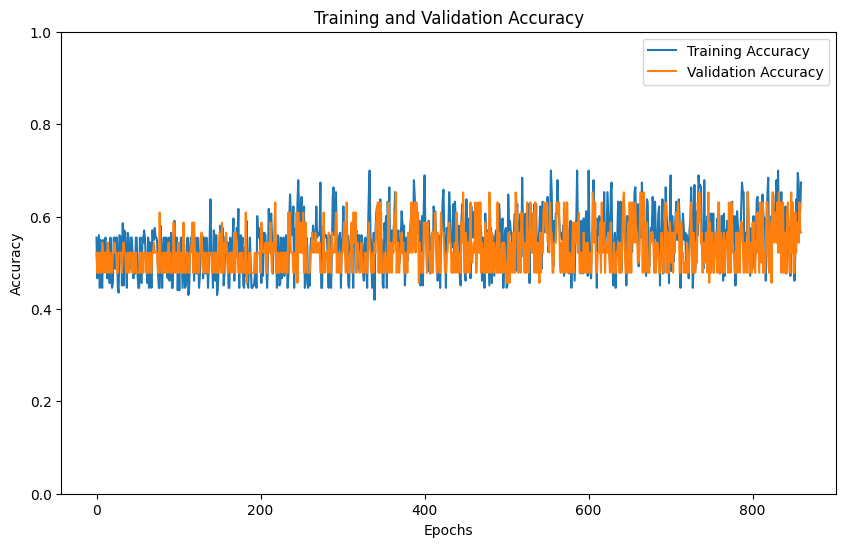

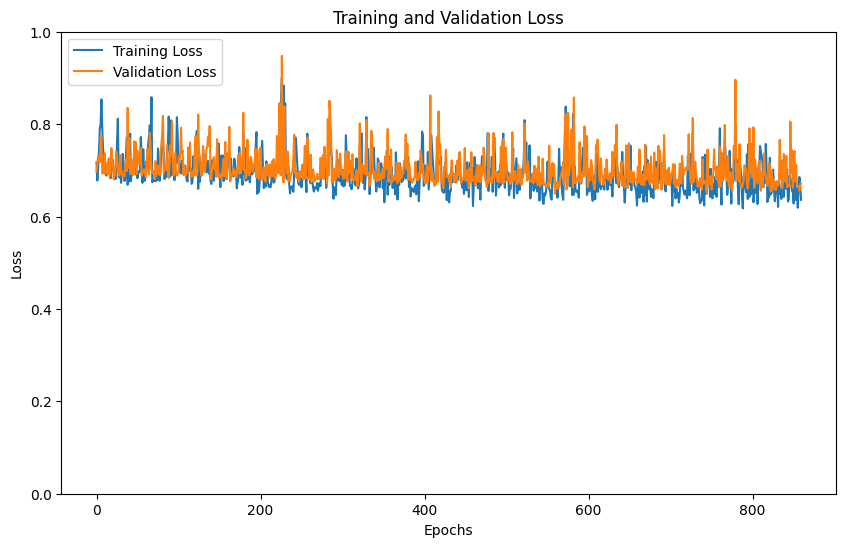

In [4]:
train_model('MobileNetV3Large', 'Adam')

#### **SGD optimizer**

Epoch 1/1000


c:\Users\alema\Desktop\paper\nodulos_tiroideos\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 569ms/step - accuracy: 0.5563 - loss: 0.7030 - val_accuracy: 0.5217 - val_loss: 0.6844
Epoch 2/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 328ms/step - accuracy: 0.4702 - loss: 0.6963 - val_accuracy: 0.5217 - val_loss: 0.8075
Epoch 3/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 324ms/step - accuracy: 0.6033 - loss: 0.6585 - val_accuracy: 0.4783 - val_loss: 0.6921
Epoch 4/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 323ms/step - accuracy: 0.4223 - loss: 0.7320 - val_accuracy: 0.4783 - val_loss: 0.7640
Epoch 5/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 325ms/step - accuracy: 0.4094 - loss: 0.7691 - val_accuracy: 0.4783 - val_loss: 0.6952
Epoch 6/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 321ms/step - accuracy: 0.4504 - loss: 0.7092 - val_accuracy: 0.4783 - val_loss: 0.7720
Epoch 7/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 372ms/step - accuracy: 0.5477 - loss: 0.6739 - val_accuracy: 0.5217 - val_loss: 0.6833
Epoch 8/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 376ms/step - accuracy: 0.3840 - loss: 0.8038 - val_accuracy: 0.5652 - val_lo

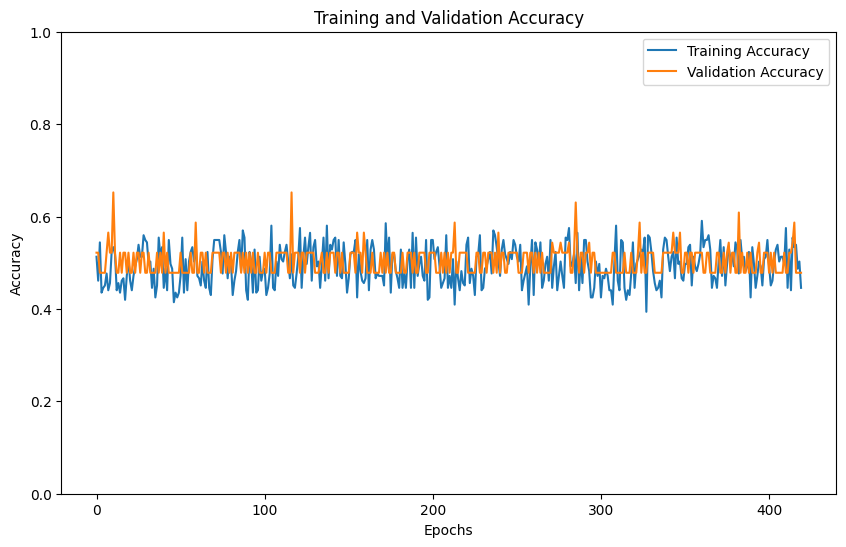

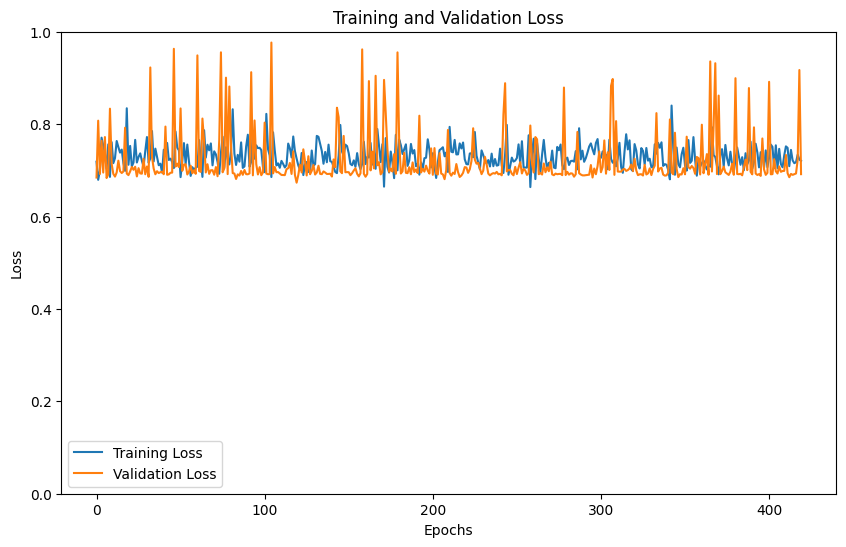

In [5]:
train_model('MobileNetV3Large', 'SGD')

## **ResNet**

### **ResNet50**

#### **Adam Optimizer**

Epoch 1/1000


c:\Users\alema\Desktop\paper\nodulos_tiroideos\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.5767 - loss: 0.8539 - val_accuracy: 0.5217 - val_loss: 0.7306
Epoch 2/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.4955 - loss: 0.8432 - val_accuracy: 0.5217 - val_loss: 0.6922
Epoch 3/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.4921 - loss: 0.8859 - val_accuracy: 0.4783 - val_loss: 0.8085
Epoch 4/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.4470 - loss: 0.7873 - val_accuracy: 0.5217 - val_loss: 0.7552
Epoch 5/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.5594 - loss: 0.7381 - val_accuracy: 0.5217 - val_loss: 0.6885
Epoch 6/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.4386 - loss: 0.7862 - val_accuracy: 0.5217 - val_loss: 0.6876
Epoch 7/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.5356 - loss: 0.7231 - val_accuracy: 0.5217 - val_loss: 0.7333
Epoch 8/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.5003 - loss: 0.7720 - val_accuracy: 0.4783 - val_loss: 1.0628
Epoch 9/1000

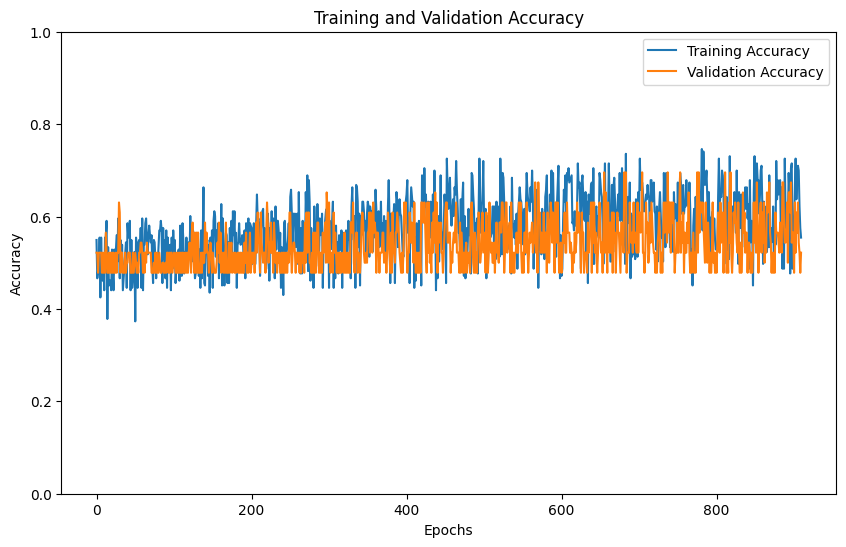

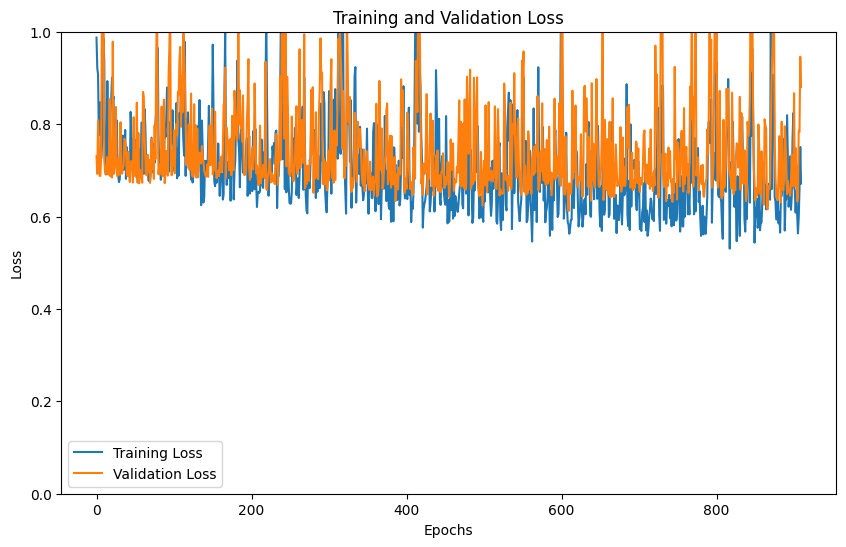

In [6]:
train_model('ResNet50', 'Adam')

#### **SGD Optimizer**

Epoch 1/1000


c:\Users\alema\Desktop\paper\nodulos_tiroideos\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.4430 - loss: 0.8781 - val_accuracy: 0.4783 - val_loss: 2.8539
Epoch 2/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.4625 - loss: 1.5934 - val_accuracy: 0.5217 - val_loss: 0.6874
Epoch 3/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.5357 - loss: 0.9671 - val_accuracy: 0.4783 - val_loss: 1.0097
Epoch 4/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.4647 - loss: 0.8955 - val_accuracy: 0.4783 - val_loss: 0.8579
Epoch 5/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.4966 - loss: 0.7898 - val_accuracy: 0.4783 - val_loss: 0.7779
Epoch 6/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.4667 - loss: 0.8428 - val_accuracy: 0.5217 - val_loss: 0.8438
Epoch 7/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.5664 - loss: 0.8328 - val_accuracy: 0.4783 - val_loss: 0.7617
Epoch 8/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.4700 - loss: 0.8440 - val_accuracy: 0.5217 - val_loss: 2.0433
Epoch 9/1

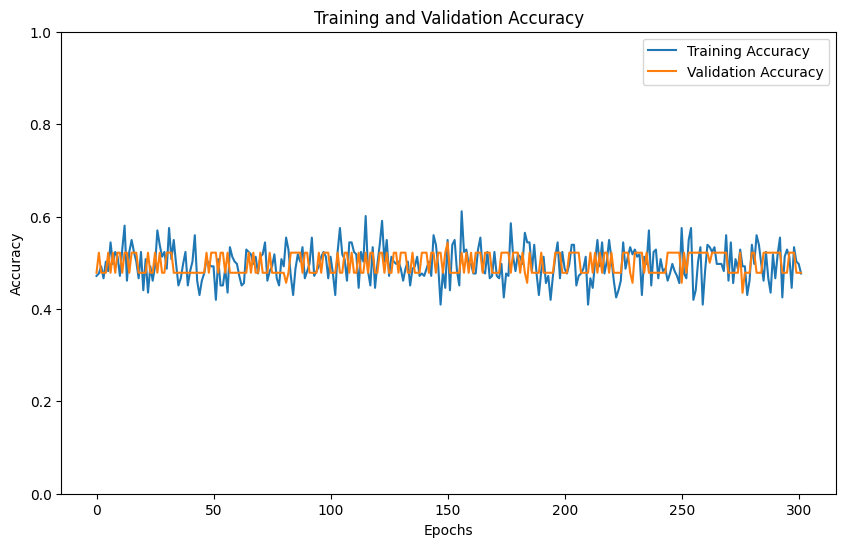

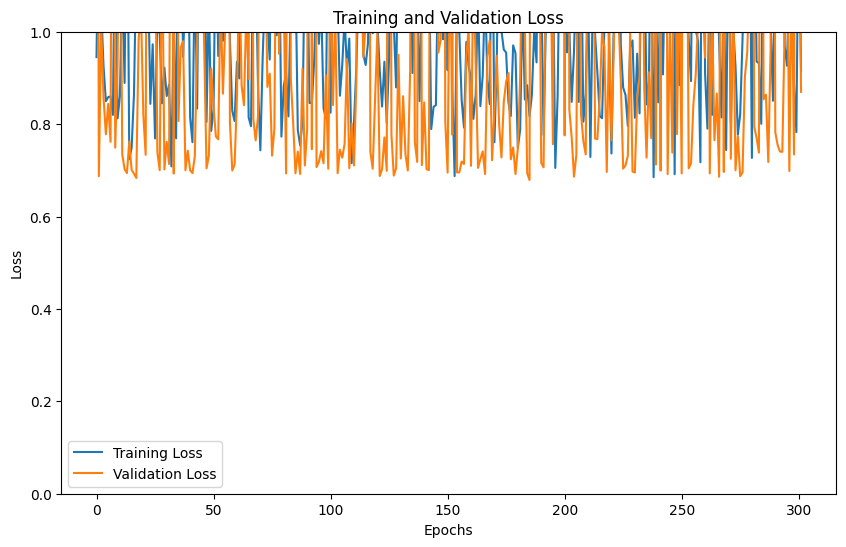

In [7]:
train_model('ResNet50', 'SGD')

### **ResNet101**

#### **Adam Optimizer**

Epoch 1/1000


c:\Users\alema\Desktop\paper\nodulos_tiroideos\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 33s 3s/step - accuracy: 0.4681 - loss: 0.8619 - val_accuracy: 0.4783 - val_loss: 0.7065
Epoch 2/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.4457 - loss: 0.7774 - val_accuracy: 0.4783 - val_loss: 0.7104
Epoch 3/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.3912 - loss: 0.7236 - val_accuracy: 0.4783 - val_loss: 0.7315
Epoch 4/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.4695 - loss: 0.7077 - val_accuracy: 0.4783 - val_loss: 0.7186
Epoch 5/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.4861 - loss: 0.7354 - val_accuracy: 0.5217 - val_loss: 0.7137
Epoch 6/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.5208 - loss: 0.7024 - val_accuracy: 0.5217 - val_loss: 0.6899
Epoch 7/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.5869 - loss: 0.6905 - val_accuracy: 0.5217 - val_loss: 0.6940
Epoch 8/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.5772 - loss: 0.7376 - val_accuracy: 0.4783 - val_loss: 0.8070
Epoch

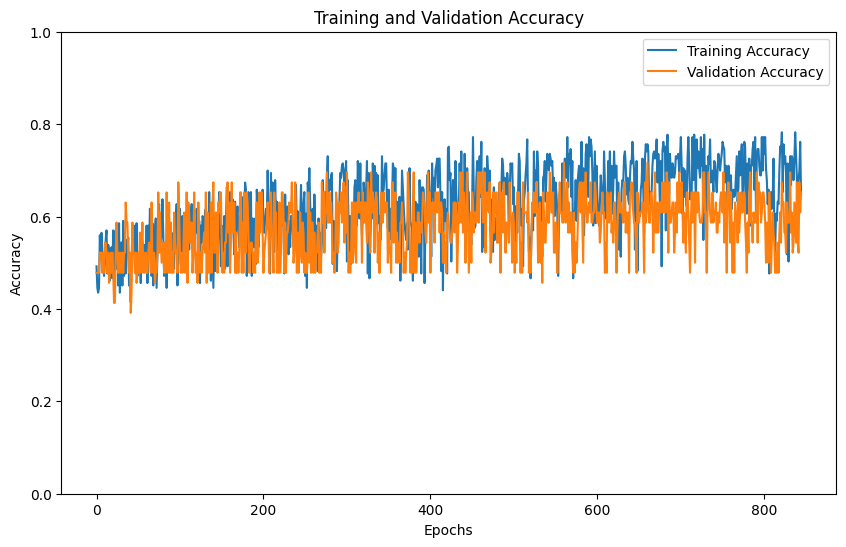

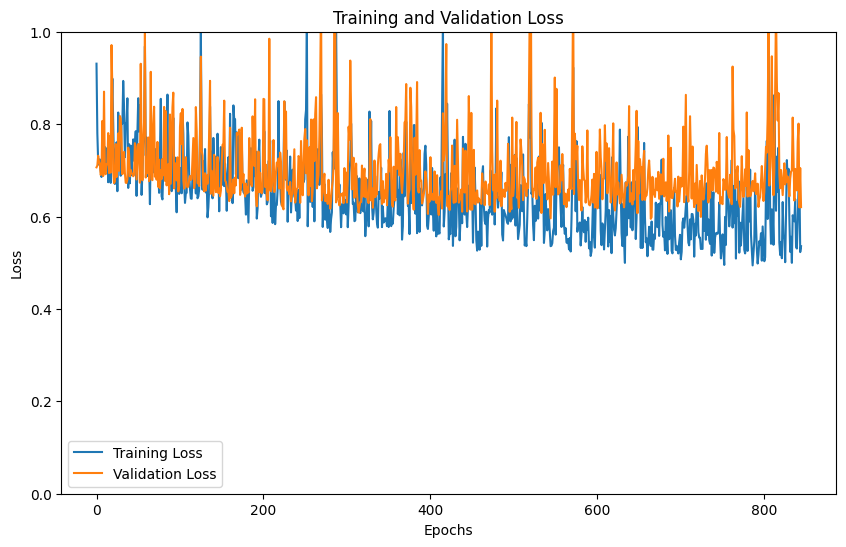

In [3]:
train_model('ResNet101', 'Adam')

#### **SGD Optimizer**

Epoch 1/1000


c:\Users\alema\Desktop\paper\nodulos_tiroideos\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 35s 3s/step - accuracy: 0.5218 - loss: 0.8479 - val_accuracy: 0.4783 - val_loss: 0.8715
Epoch 2/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.4906 - loss: 0.8278 - val_accuracy: 0.4783 - val_loss: 0.9232
Epoch 3/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.5132 - loss: 0.8951 - val_accuracy: 0.5217 - val_loss: 0.7043
Epoch 4/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.5572 - loss: 0.8000 - val_accuracy: 0.4783 - val_loss: 0.7456
Epoch 5/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.4634 - loss: 0.8515 - val_accuracy: 0.5217 - val_loss: 0.6827
Epoch 6/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.4615 - loss: 0.7493 - val_accuracy: 0.4783 - val_loss: 0.7403
Epoch 7/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.4351 - loss: 1.0350 - val_accuracy: 0.4783 - val_loss: 0.8043
Epoch 8/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.3997 - loss: 0.8461 - val_accuracy: 0.4783 - val_loss: 0.7400
Epoch

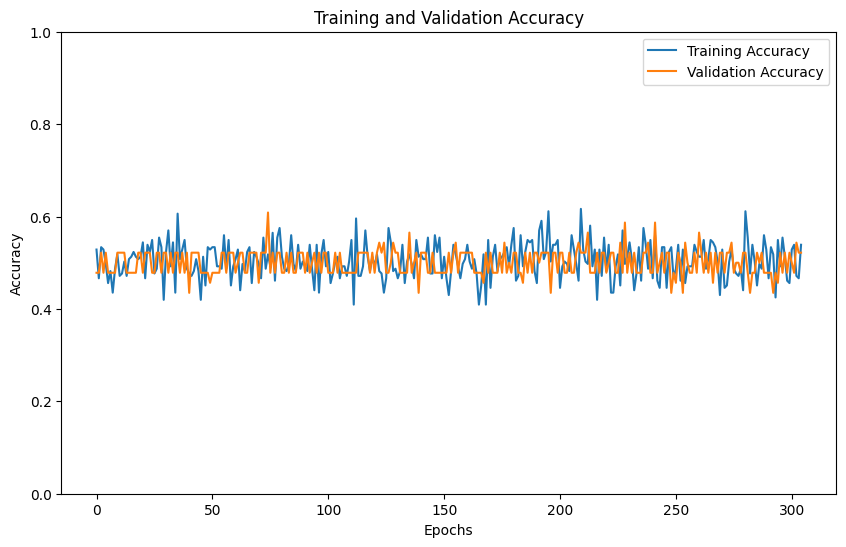

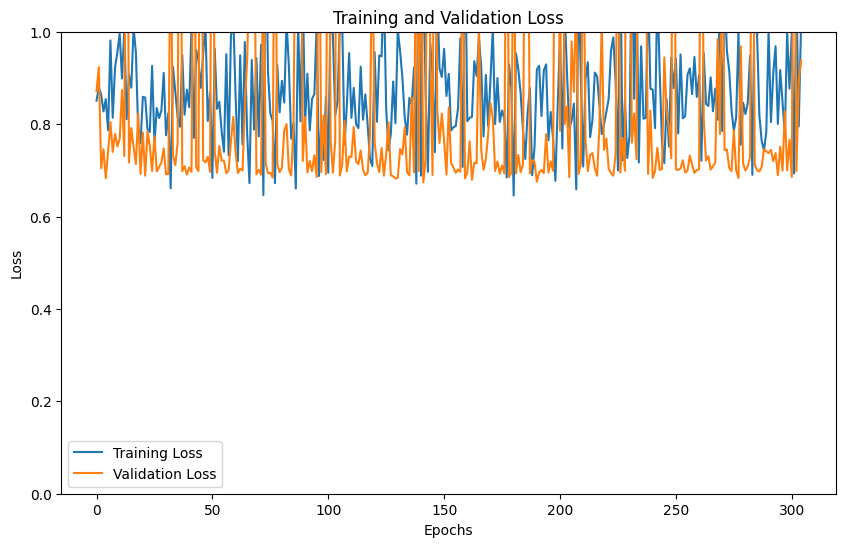

In [ ]:
train_model('ResNet101', 'SGD')

## **VGG**

### **VGG16**

#### **Adam Optimizer**

Epoch 1/1000


c:\Users\alema\Desktop\paper\nodulos_tiroideos\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - accuracy: 0.4243 - loss: 0.7408 - val_accuracy: 0.4783 - val_loss: 0.7025
Epoch 2/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.4404 - loss: 0.7309 - val_accuracy: 0.4783 - val_loss: 0.7585
Epoch 3/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 26s 4s/step - accuracy: 0.4422 - loss: 0.7672 - val_accuracy: 0.5217 - val_loss: 0.7320
Epoch 4/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 27s 4s/step - accuracy: 0.5400 - loss: 0.7830 - val_accuracy: 0.5217 - val_loss: 0.6926
Epoch 5/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 27s 4s/step - accuracy: 0.5270 - loss: 0.6872 - val_accuracy: 0.4783 - val_loss: 0.6875
Epoch 6/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 27s 4s/step - accuracy: 0.4782 - loss: 0.6967 - val_accuracy: 0.5435 - val_loss: 0.6884
Epoch 7/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 28s 4s/step - accuracy: 0.5377 - loss: 0.6915 - val_accuracy: 0.5217 - val_loss: 0.7538
Epoch 8/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 29s 4s/step - accuracy: 0.5548 - loss: 0.7487 - val_accuracy: 0.4565 - val_loss: 0.7115
Epoch

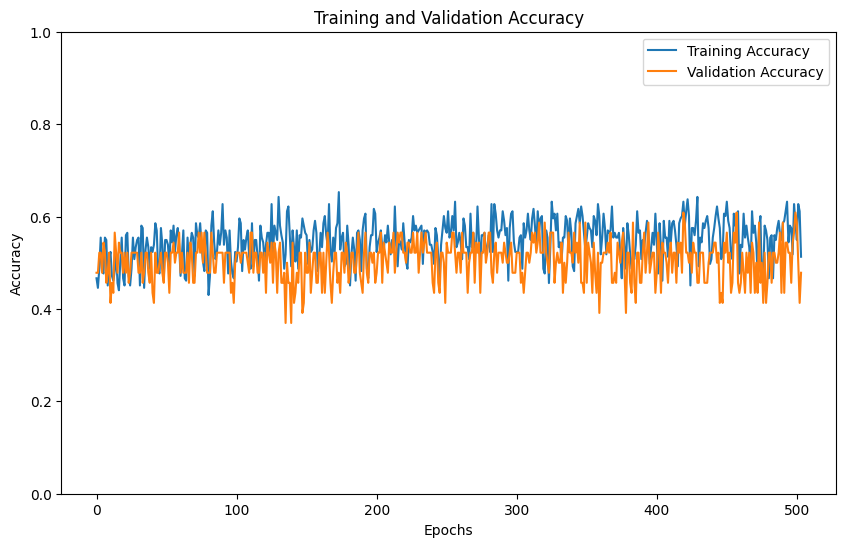

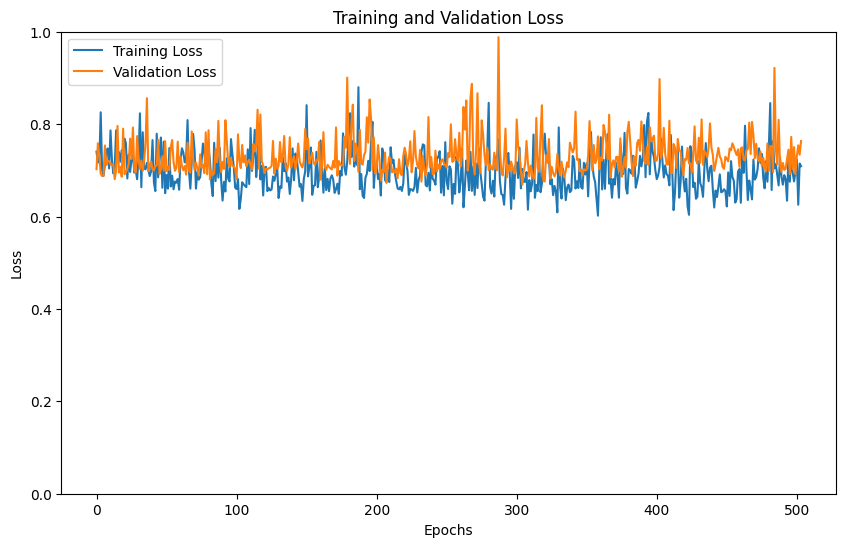

In [ ]:
train_model('VGG16', 'Adam')

#### **SGD Optimizer**

Epoch 1/1000


c:\Users\alema\Desktop\paper\nodulos_tiroideos\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 28s 4s/step - accuracy: 0.4641 - loss: 0.7484 - val_accuracy: 0.4783 - val_loss: 0.7359
Epoch 2/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 28s 4s/step - accuracy: 0.4579 - loss: 0.7045 - val_accuracy: 0.5217 - val_loss: 0.7094
Epoch 3/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 27s 4s/step - accuracy: 0.5510 - loss: 0.6759 - val_accuracy: 0.5217 - val_loss: 0.6982
Epoch 4/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 28s 4s/step - accuracy: 0.4628 - loss: 0.7026 - val_accuracy: 0.5217 - val_loss: 0.6873
Epoch 5/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 28s 4s/step - accuracy: 0.5170 - loss: 0.7009 - val_accuracy: 0.4783 - val_loss: 0.7155
Epoch 6/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 27s 4s/step - accuracy: 0.4563 - loss: 0.7146 - val_accuracy: 0.5217 - val_loss: 0.6988
Epoch 7/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 28s 4s/step - accuracy: 0.5022 - loss: 0.6980 - val_accuracy: 0.4783 - val_loss: 0.7286
Epoch 8/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 28s 4s/step - accuracy: 0.4288 - loss: 0.7238 - val_accuracy: 0.4783 - val_loss: 0.8185
Epoch

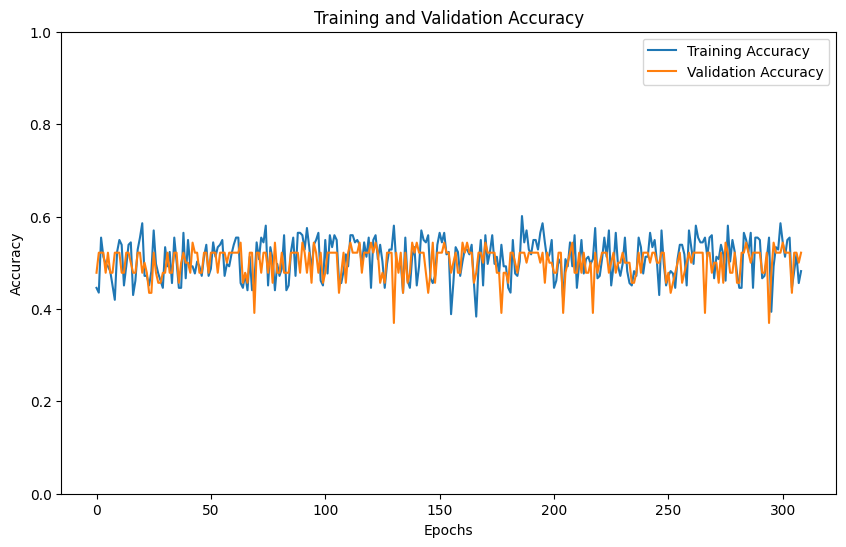

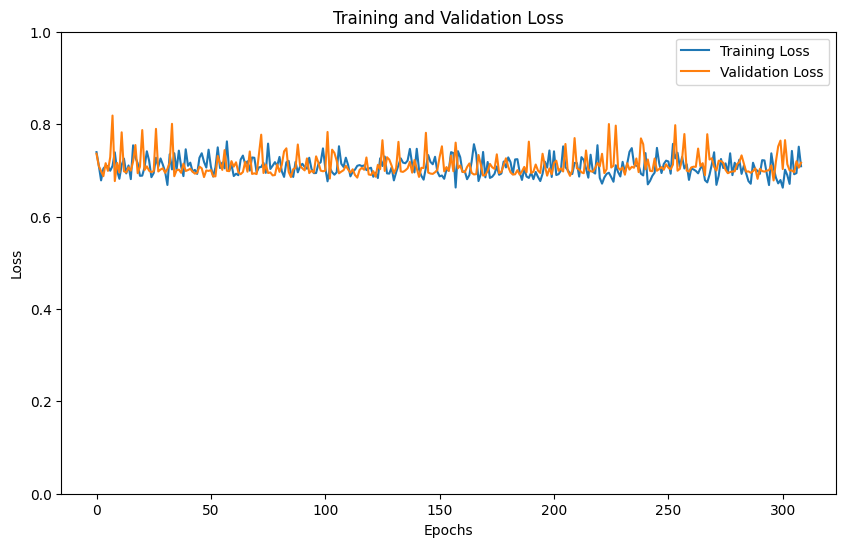

In [ ]:
train_model('VGG16', 'SGD')

### **VGG19**

#### **Adam Optimizer**

Epoch 1/1000


c:\Users\alema\Desktop\paper\nodulos_tiroideos\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 33s 5s/step - accuracy: 0.4858 - loss: 0.7412 - val_accuracy: 0.5435 - val_loss: 0.6920
Epoch 2/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 38s 5s/step - accuracy: 0.4916 - loss: 0.6870 - val_accuracy: 0.4783 - val_loss: 0.8440
Epoch 3/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 38s 6s/step - accuracy: 0.5167 - loss: 0.6623 - val_accuracy: 0.5000 - val_loss: 0.7021
Epoch 4/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 34s 5s/step - accuracy: 0.5001 - loss: 0.7116 - val_accuracy: 0.5217 - val_loss: 0.8216
Epoch 5/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 34s 5s/step - accuracy: 0.5477 - loss: 0.7606 - val_accuracy: 0.4565 - val_loss: 0.7026
Epoch 6/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 37s 6s/step - accuracy: 0.6001 - loss: 0.6667 - val_accuracy: 0.5217 - val_loss: 0.7056
Epoch 7/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 37s 5s/step - accuracy: 0.4873 - loss: 0.7459 - val_accuracy: 0.4783 - val_loss: 0.7686
Epoch 8/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 38s 5s/step - accuracy: 0.4831 - loss: 0.7180 - val_accuracy: 0.5000 - val_loss: 0.7022
Epoch

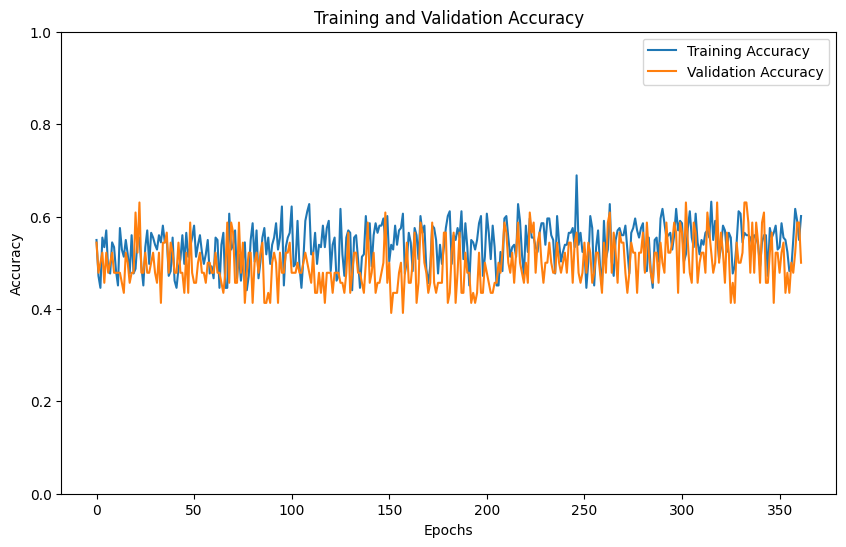

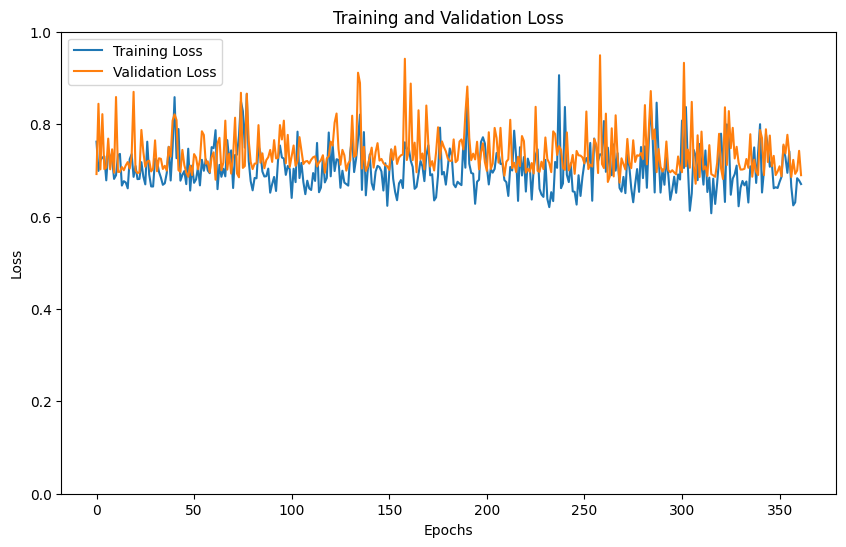

In [ ]:
train_model('VGG19', 'Adam')

#### **SDG Optimizer**

Epoch 1/1000


c:\Users\alema\Desktop\paper\nodulos_tiroideos\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 33s 4s/step - accuracy: 0.4335 - loss: 0.7337 - val_accuracy: 0.5000 - val_loss: 0.7039
Epoch 2/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 32s 5s/step - accuracy: 0.5611 - loss: 0.6874 - val_accuracy: 0.5217 - val_loss: 0.6963
Epoch 3/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 32s 5s/step - accuracy: 0.5573 - loss: 0.7059 - val_accuracy: 0.5217 - val_loss: 0.7089
Epoch 4/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 33s 5s/step - accuracy: 0.4182 - loss: 0.7140 - val_accuracy: 0.5217 - val_loss: 0.7485
Epoch 5/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 31s 4s/step - accuracy: 0.5393 - loss: 0.7466 - val_accuracy: 0.4783 - val_loss: 0.7190
Epoch 6/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 33s 5s/step - accuracy: 0.4956 - loss: 0.7079 - val_accuracy: 0.5217 - val_loss: 0.7042
Epoch 7/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 35s 5s/step - accuracy: 0.5316 - loss: 0.6981 - val_accuracy: 0.5217 - val_loss: 0.7097
Epoch 8/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 36s 5s/step - accuracy: 0.5619 - loss: 0.7095 - val_accuracy: 0.5217 - val_loss: 0.7122
Epoch

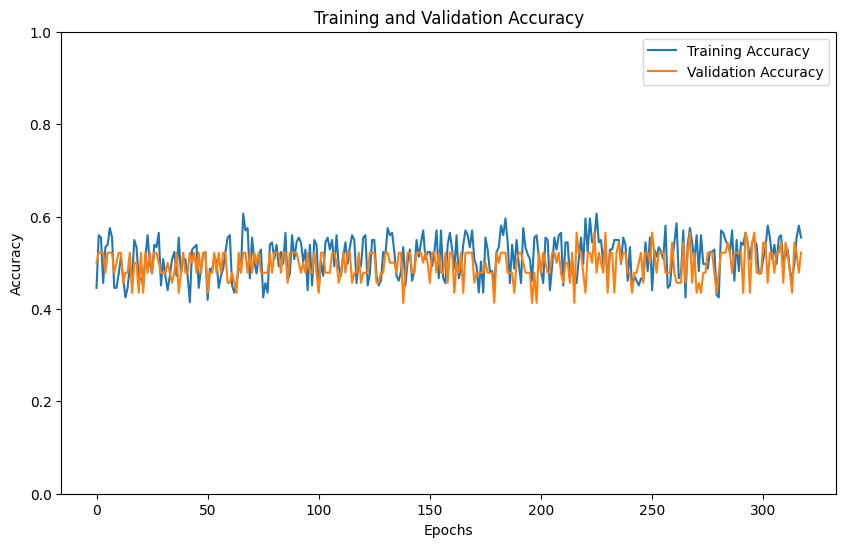

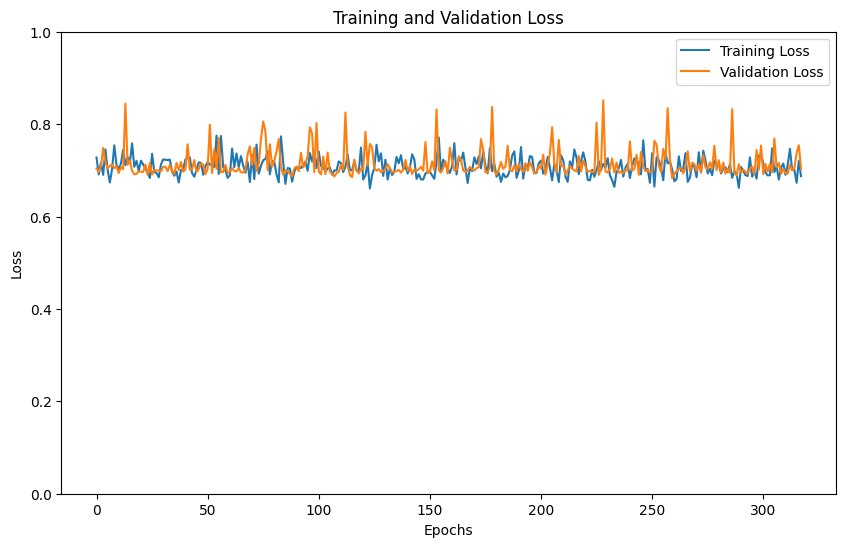

In [ ]:
train_model('VGG19', 'SGD')

## **Xception**

### **Adam**

Epoch 1/1000


c:\Users\alema\Desktop\paper\nodulos_tiroideos\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.5079 - loss: 0.9979 - val_accuracy: 0.4783 - val_loss: 0.8049
Epoch 2/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.5512 - loss: 0.6733 - val_accuracy: 0.5217 - val_loss: 0.8134
Epoch 3/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.5481 - loss: 0.7872 - val_accuracy: 0.4783 - val_loss: 0.7538
Epoch 4/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.5096 - loss: 0.7317 - val_accuracy: 0.5217 - val_loss: 0.8037
Epoch 5/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 33s 4s/step - accuracy: 0.5952 - loss: 0.6701 - val_accuracy: 0.5000 - val_loss: 0.8225
Epoch 6/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 31s 4s/step - accuracy: 0.4567 - loss: 0.8905 - val_accuracy: 0.4783 - val_loss: 0.8687
Epoch 7/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 31s 4s/step - accuracy: 0.5253 - loss: 0.7505 - val_accuracy: 0.5217 - val_loss: 1.0332
Epoch 8/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 30s 4s/step - accuracy: 0.5768 - loss: 0.8616 - val_accuracy: 0.4130 - val_loss: 0.8674
Epoch

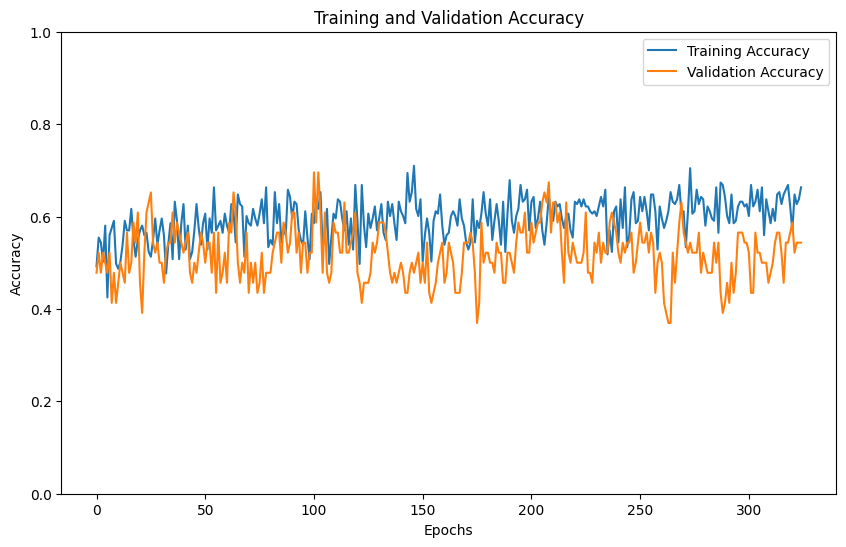

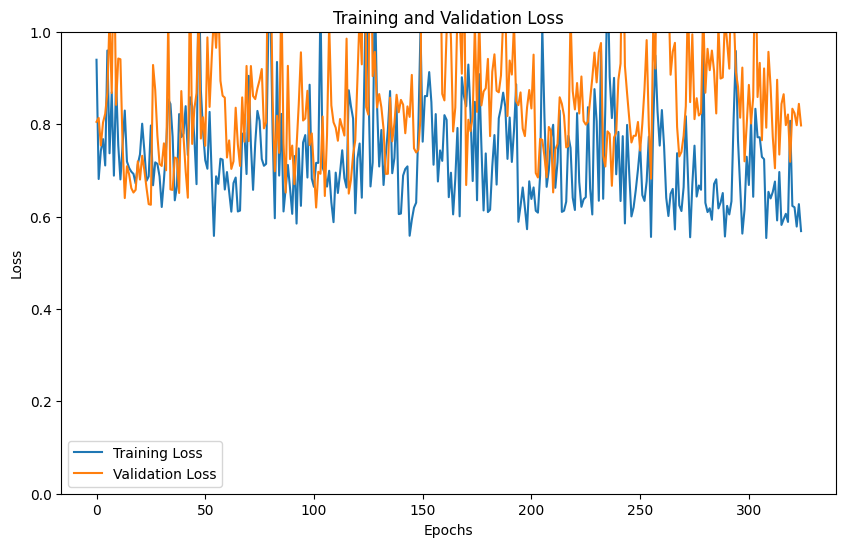

In [ ]:
train_model('Xception', 'Adam')

### **SGD**

Epoch 1/1000


c:\Users\alema\Desktop\paper\nodulos_tiroideos\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.4363 - loss: 0.6929 - val_accuracy: 0.4348 - val_loss: 0.7524
Epoch 2/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.4951 - loss: 0.7142 - val_accuracy: 0.4130 - val_loss: 0.7034
Epoch 3/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.4525 - loss: 0.7077 - val_accuracy: 0.4565 - val_loss: 0.7158
Epoch 4/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.4140 - loss: 0.7348 - val_accuracy: 0.4565 - val_loss: 0.7434
Epoch 5/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.4923 - loss: 0.7144 - val_accuracy: 0.3913 - val_loss: 0.7242
Epoch 6/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.4896 - loss: 0.7050 - val_accuracy: 0.3696 - val_loss: 0.7095
Epoch 7/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.6027 - loss: 0.6880 - val_accuracy: 0.5217 - val_loss: 0.7261
Epoch 8/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.4917 - loss: 0.6901 - val_accuracy: 0.5000 - val_loss: 0.7243
Epoch

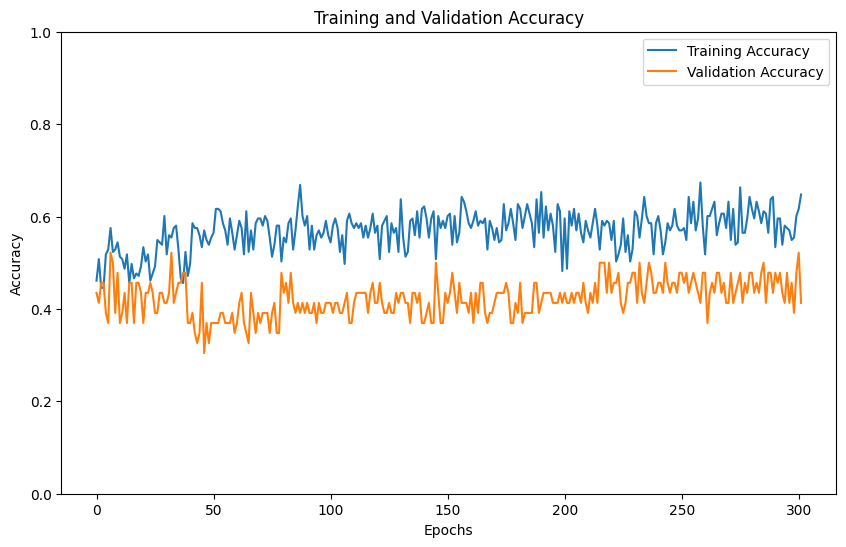

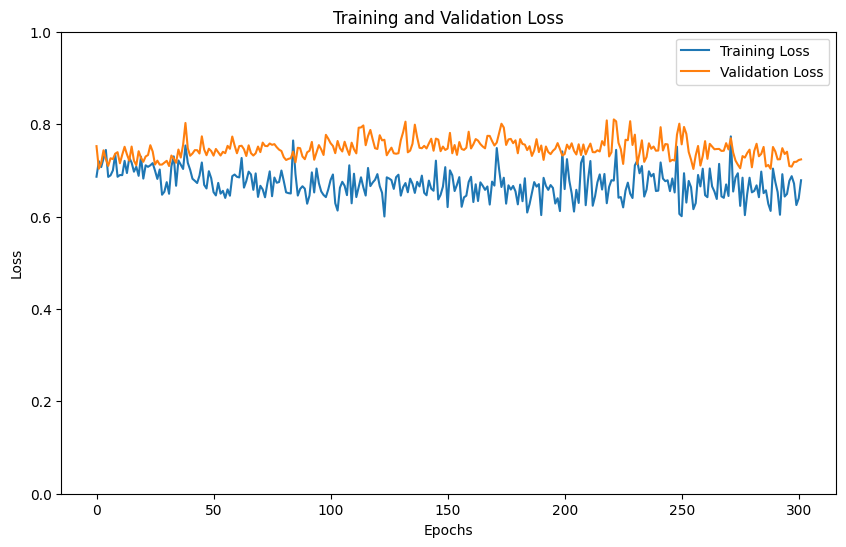

In [ ]:
train_model('Xception', 'SGD')

## **DenseNet**

### **Adam**

Epoch 1/1000


c:\Users\alema\Desktop\paper\nodulos_tiroideos\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.5123 - loss: 0.7834 - val_accuracy: 0.5217 - val_loss: 0.7472
Epoch 2/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.5174 - loss: 0.8070 - val_accuracy: 0.4348 - val_loss: 0.7191
Epoch 3/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.4351 - loss: 0.8630 - val_accuracy: 0.5217 - val_loss: 1.0152
Epoch 4/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.4086 - loss: 1.0509 - val_accuracy: 0.4783 - val_loss: 0.9269
Epoch 5/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.4490 - loss: 0.8560 - val_accuracy: 0.5000 - val_loss: 0.8756
Epoch 6/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.3924 - loss: 1.1282 - val_accuracy: 0.4783 - val_loss: 1.0071
Epoch 7/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.4422 - loss: 0.7913 - val_accuracy: 0.5217 - val_loss: 0.8289
Epoch 8/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.5848 - loss: 0.6344 - val_accuracy: 0.4783 - val_loss: 0.7251
Epoch

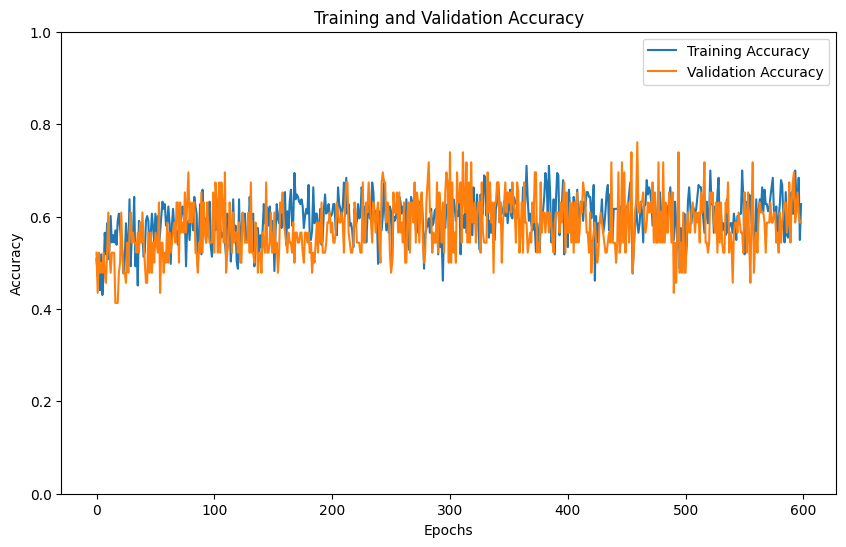

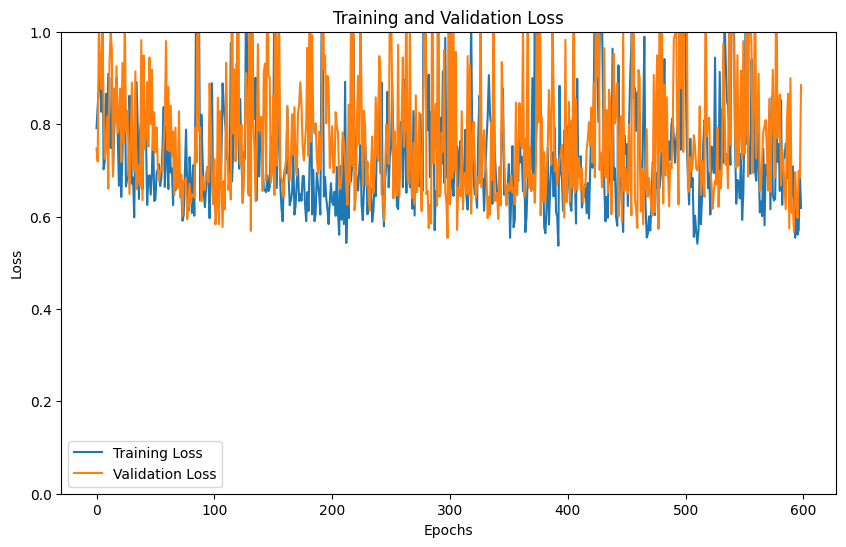

In [ ]:
train_model('DenseNet', 'Adam')

### **SGD**

Epoch 1/1000


c:\Users\alema\Desktop\paper\nodulos_tiroideos\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.5423 - loss: 0.6706 - val_accuracy: 0.6087 - val_loss: 0.6727
Epoch 2/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.5077 - loss: 0.7138 - val_accuracy: 0.4783 - val_loss: 0.8938
Epoch 3/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.4457 - loss: 0.8291 - val_accuracy: 0.5435 - val_loss: 0.6715
Epoch 4/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.5292 - loss: 0.6789 - val_accuracy: 0.5000 - val_loss: 0.7167
Epoch 5/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.5437 - loss: 0.7783 - val_accuracy: 0.5652 - val_loss: 0.6410
Epoch 6/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.5393 - loss: 0.7044 - val_accuracy: 0.5652 - val_loss: 0.6575
Epoch 7/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.5441 - loss: 0.7088 - val_accuracy: 0.4783 - val_loss: 0.7368
Epoch 8/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.4637 - loss: 0.9707 - val_accuracy: 0.5217 - val_loss: 0.6879
Epoch

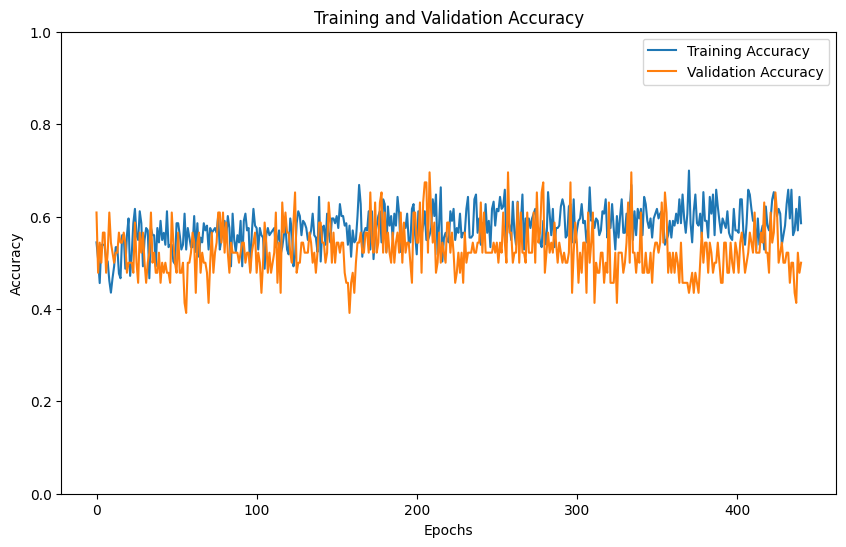

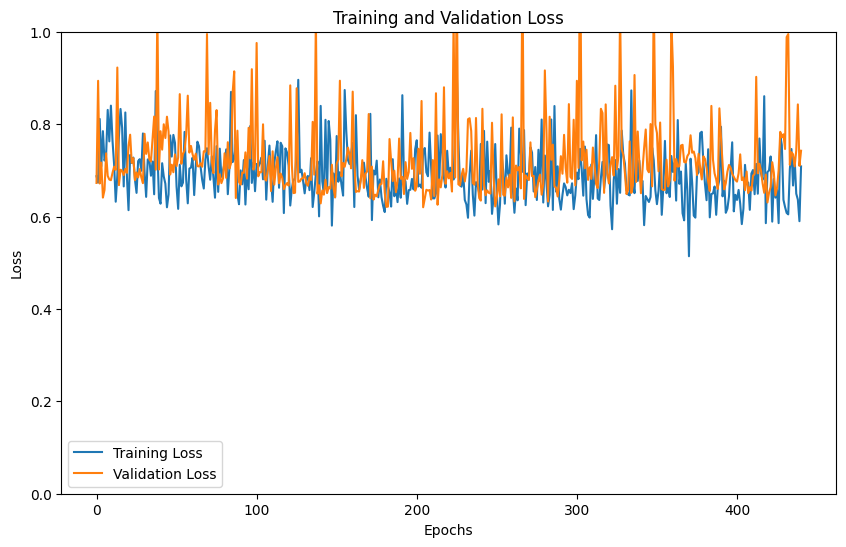

In [ ]:
train_model('DenseNet', 'SGD')